In [1]:
import pandas
from peanut.smpi_hpl import SMPIHPL
from peanut.peanut import ExpFile, RunError
import peanut
print(peanut.__git_version__)

f6b876d42ce4ebff4c12ad9dbd26e894f5f880a8


In [2]:
if True:
    job = SMPIHPL.oarsub_cluster(cluster='dahu', username='tocornebize', walltime='02:00:00', deploy='debian9-x64-base', nb_nodes=1)
    job.trace_execution = True
    job.setup()
else:
    job = SMPIHPL.get_jobs('nancy', 'tocornebize')[0]
    job.trace_execution = True
    job.nodes.run('pwd')

[2019-01-14 09:00:39][DEBUG] [frontend | /home/tocornebize] oarsub -n "🥐" -q default -t deploy  -l "{cluster in ('dahu')}/nodes=1,walltime=02:00:00" -r "2019-01-14 09:00:39"
[2019-01-14 09:00:42][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1839830
[2019-01-14 09:00:48][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1839830
[2019-01-14 09:00:59][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1839830
[2019-01-14 09:01:20][DEBUG] [frontend | /home/tocornebize] oarstat -fJ -j 1839830
[2019-01-14 09:01:21][DEBUG] [frontend | /home/tocornebize] kadeploy3 -k -f /var/lib/oar/1839830 -e debian9-x64-base
[2019-01-14 09:04:49][DEBUG] [allnodes | /tmp] echo "hello world"
[2019-01-14 09:04:49][DEBUG] [allnodes | /tmp] rm -rf /tmp/*
[2019-01-14 09:04:50][DEBUG] [director | /tmp] echo UEsFBgAAAAAAAAAAAAAAAAAAAAAAAA== | base64 -d > grenoble_2019-01-14_1839830.zip
[2019-01-14 09:04:50][DEBUG] [director | /root] ssh-keygen -b 2048 -t rsa -f .ssh/id_rsa -q -N ""
[2019-01-14 09:04:50]

We have applied an ad-hoc patch to HPL, so let's commit it so as to not remove it then.

In [3]:
job.nodes.run('git commit -am "bla"', directory=job.hpl_dir)

[2019-01-14 09:08:31][DEBUG] [allnodes | /tmp/hpl-2.2] git commit -am "bla"


{<Connection host=dahu-4.grenoble.grid5000.fr user=root gw=proxyjump>: <Result cmd='cd /tmp/hpl-2.2 && git commit -am "bla"' exited=0>}

## Gathering a trace with optimization level 1

In [4]:
def build_hpl(job, opt_level):
    job.nodes.run('git clean -xfd .', directory=job.hpl_dir)
    options = '-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=%d' % opt_level
    while True:
        try:
            job.nodes.run('make SMPI_OPTS="%s" arch=SMPI' % options, directory=job.hpl_dir)
        except RunError as e:  # for some reason, this command fails sometime...
            msg = str(e).split('\n')[0]
            logger.error('Previous command failed with message %s' % msg)
        else:
            break

In [5]:
build_hpl(job, 1)

[2019-01-14 09:08:31][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:08:31][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=1" arch=SMPI


Let's take the experiment files I used previously.

In [6]:
!unzip -p grenoble_2018-12-18_1829370.zip exp_smpi.csv > /tmp/exp_smpi.csv
!unzip -p grenoble_2018-12-18_1829370.zip dahu.xml > /tmp/dahu.xml
job.expfile = [ExpFile(filename='/tmp/exp_smpi.csv', types=job.expfile_types, header=job.expfile_header, header_in_file=job.expfile_header_in_file),
               ExpFile(filename='/tmp/dahu.xml')]

In [7]:
job.expfile[0].content

[{'matrix_size': 50000,
  'block_size': 128,
  'proc_p': 2,
  'proc_q': 4,
  'pfact': 1,
  'rfact': 2,
  'bcast': 2,
  'depth': 1,
  'swap': 0,
  'mem_align': 8,
  'process_per_node': 1,
  'thread_per_process': 32,
  'dgemm_coefficient': 2.548998e-12,
  'dgemm_intercept': 9.905042e-05,
  'dtrsm_coefficient': 4.524788e-12,
  'dtrsm_intercept': 3.975362e-05}]

In [8]:
print(job.expfile[1].raw_content)

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

In [9]:
job.run_exp()

[2019-01-14 09:08:49][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpw_gxxw2y → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:08:49][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp8_m6x4x5 → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:08:49][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmph2hfqt78 → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:08:50][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:08:50][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpjs8eltk9 → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:08:50][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [10]:
def get_trace(job, functions, ranks):
    func_reg = '|'.join(functions)
    rank_reg = '|'.join(['rank-%d' % r for r in ranks])
    cmd = 'grep -E "%s" /tmp/trace_mpi_0.csv | grep -E "%s" > /tmp/mpi.csv' % (func_reg, rank_reg)
    job.nodes.run(cmd)
    job.nodes.get('/tmp/mpi.csv', '/tmp/mpi.csv')
    df = pandas.read_csv('/tmp/mpi.csv', names=['type', 'rank', 'container', 'start', 'end', 'duration', 'level', 'function', 'msg_size'])
    df['function'] = df['function'].str.replace('PMPI', 'MPI').str.strip()
    df['rank'] = df['rank'].str.slice(6).astype(int)  # changing 'rank-42' into 42
    return df.sort_values(by=['rank', 'start'])

trace_level1 = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_level1.head()

[2019-01-14 09:14:01][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:14:04][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
670634,State,0,MPI_STATE,0.000000,0.000085,0.000085,0.0,computing,0.000085
670635,State,0,MPI_STATE,0.000085,0.000087,0.000002,0.0,MPI_Recv,4.000000
670636,State,0,MPI_STATE,0.000087,0.000088,0.000001,0.0,computing,0.000002
670637,State,0,MPI_STATE,0.000088,0.000090,0.000002,0.0,MPI_Recv,4.000000
670638,State,0,MPI_STATE,0.000090,0.000091,0.000001,0.0,MPI_Recv,4.000000


In [11]:
trace_level1.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.511708e+10,0.000000
MPI_Recv,3.023868e+10,3.339951
MPI_Send,4.535576e+10,58.247144
computing,2.179918e+02,217.980549


## Gathering a trace with optimization level 4

In [12]:
build_hpl(job, 4)

[2019-01-14 09:14:09][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:14:09][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=4" arch=SMPI


In [13]:
job.run_exp()

[2019-01-14 09:14:26][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp1oqxyhyz → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:14:26][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpfm8f3kuh → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:14:26][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp3ll4ktb1 → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:14:27][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:14:27][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmppuupd09n → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:14:27][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [14]:
trace_level4 = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_level4.head()

[2019-01-14 09:15:00][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:15:03][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
602335,State,0,MPI_STATE,0.000000,0.000068,0.000068,0.0,computing,0.000068
602336,State,0,MPI_STATE,0.000068,0.000069,0.000001,0.0,MPI_Recv,4.000000
602337,State,0,MPI_STATE,0.000069,0.000071,0.000002,0.0,computing,0.000001
602338,State,0,MPI_STATE,0.000071,0.000072,0.000001,0.0,MPI_Recv,4.000000
602339,State,0,MPI_STATE,0.000072,0.000073,0.000001,0.0,MPI_Recv,4.000000


In [15]:
trace_level4.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.508871e+10,0.000000
MPI_Recv,3.023268e+10,2.574183
MPI_Send,4.532139e+10,7.548743
computing,1.740831e+00,1.707108


## Patching my version of HPL

First, let's get the original source code.

In [16]:
job.nodes.run('wget http://www.netlib.org/benchmark/hpl/hpl-2.2.tar.gz')
job.nodes.run('mkdir original')
job.nodes.run('tar -xvf hpl-2.2.tar.gz -C original')

[2019-01-14 09:15:06][DEBUG] [allnodes | /tmp] wget http://www.netlib.org/benchmark/hpl/hpl-2.2.tar.gz
[2019-01-14 09:15:07][DEBUG] [allnodes | /tmp] mkdir original
[2019-01-14 09:15:07][DEBUG] [allnodes | /tmp] tar -xvf hpl-2.2.tar.gz -C original


{<Connection host=dahu-4.grenoble.grid5000.fr user=root gw=proxyjump>: <Result cmd='cd /tmp && tar -xvf hpl-2.2.tar.gz -C original' exited=0>}

In [17]:
def change_hpl_files(job, filenames, original_dir='/tmp/original/hpl-2.2'):
    for file in filenames:
        job.nodes.run('cp -f %s/%s %s/%s' % (original_dir, file, job.hpl_dir, file))

In [18]:
def remove_hpl_lines(job, filename, lines):
    lines = ';'.join(['%dd' % l for l in lines])
    job.nodes.run('sed -i -e "%s" %s/%s' % (lines, job.hpl_dir, filename))

In [19]:
def patch_hpl(job, *patches):
    job.nodes.run('git checkout src include testing', directory=job.hpl_dir)
    job.nodes.run('git clean -xfd .', directory=job.hpl_dir)
    for func, *args in patches:
        func(job, *args)
    build_hpl(job, 4)
    print(job.nodes.run_unique('git diff --color src include testing', directory=job.hpl_dir).stdout)

### HPL utility functions

In [20]:
files = [
    'src/auxil/HPL_dlatcpy.c',
    'src/auxil/HPL_dlacpy.c',
    'src/pauxil/HPL_dlaswp01T.c',
    'src/pauxil/HPL_dlaswp06T.c',
    'src/pauxil/HPL_dlaswp00N.c',
    'src/pauxil/HPL_dlaswp05N.c',
    'src/pauxil/HPL_dlaswp03T.c',
    'src/pauxil/HPL_dlaswp10N.c',
    'src/pauxil/HPL_dlaswp05T.c',
    'src/pauxil/HPL_dlaswp02N.c',
    'src/pauxil/HPL_dlaswp03N.c',
    'src/pauxil/HPL_dlaswp01N.c',
    'src/pauxil/HPL_dlaswp04N.c',
    'src/pauxil/HPL_dlaswp04T.c',
    'src/pauxil/HPL_dlaswp06N.c',
]
patch_utility = (change_hpl_files, files)
patch_hpl(job, patch_utility)

[2019-01-14 09:15:07][DEBUG] [allnodes | /tmp/hpl-2.2] git checkout src include testing
[2019-01-14 09:15:07][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/auxil/HPL_dlatcpy.c hpl-2.2/src/auxil/HPL_dlatcpy.c
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/auxil/HPL_dlacpy.c hpl-2.2/src/auxil/HPL_dlacpy.c
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp01T.c hpl-2.2/src/pauxil/HPL_dlaswp01T.c
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp06T.c hpl-2.2/src/pauxil/HPL_dlaswp06T.c
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp00N.c hpl-2.2/src/pauxil/HPL_dlaswp00N.c
[2019-01-14 09:15:08][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp05N.c hpl-2.2/src/pauxil/HPL_dlaswp05N.c
[2019-01-14 09:15:09][DEBUG] [al

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 8c1396a..89ae13b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -127,9 +127,6 @@ void HPL_dlacpy
 /*
  * .. Local Variables ..
  */
-#if SMPI_OPTIMIZATION_LEVEL >= 2
-    return;
-#endif
 #ifdef HPL_LACPY_USE_COPY
    register int               j;
 #else
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 417a1d5..7643676 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -127,9 +127,6 @@ void HPL_dlatcpy
 /*
  * .. Local Variables ..
  */
-#if SMPI_OPTIMIZATION_LEVEL >= 2
-    return;
-#endif
 #ifdef HPL_LATCPY_USE_COPY
    register int               j;
 #else
diff --git a/src/pauxil/HPL_dlaswp00N.c b/src/pauxil/HPL_dlaswp00N.c
index 2cab3c3..60ae8b1 100644
--- a/src/pauxil/HPL_dlaswp00N.c
+++ b/src/pauxil/HPL_dlaswp00N.c
@@ -112,9 +112,6 @@ void HPL_dlaswp00N
 /*
  * .. Local Variables ..
  */
-#if SMPI_OPTIMIZATION_LEVEL >= 2
-    return;
-#endif
    register d

In [21]:
job.run_exp()

[2019-01-14 09:15:27][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp2qkmhz22 → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:15:28][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpwy6oljzm → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:15:28][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp990684ch → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:15:28][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:15:28][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp6ev73ezw → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:15:28][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [22]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:16:13][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:16:17][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
592658,State,0,MPI_STATE,0.000000,0.000081,0.000081,0.0,computing,0.000081
592659,State,0,MPI_STATE,0.000081,0.000082,0.000001,0.0,MPI_Recv,4.000000
592660,State,0,MPI_STATE,0.000082,0.000083,0.000001,0.0,computing,0.000001
592661,State,0,MPI_STATE,0.000083,0.000085,0.000002,0.0,MPI_Recv,4.000000
592662,State,0,MPI_STATE,0.000085,0.000086,0.000001,0.0,MPI_Recv,4.000000


In [23]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.513166e+10,0.000000
MPI_Recv,3.023268e+10,2.574159
MPI_Send,4.536435e+10,10.340138
computing,1.461248e+01,14.593082


### BLAS functions

In [24]:
patch_blas = (remove_hpl_lines, 'include/hpl_blas.h', list(range(164, 174))+[182])
patch_hpl(job, patch_blas)

[2019-01-14 09:16:20][DEBUG] [allnodes | /tmp/hpl-2.2] git checkout src include testing
[2019-01-14 09:16:20][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:16:20][DEBUG] [allnodes | /tmp] sed -i -e "164d;165d;166d;167d;168d;169d;170d;171d;172d;173d;182d" hpl-2.2/include/hpl_blas.h
[2019-01-14 09:16:21][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:16:21][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=4" arch=SMPI
[2019-01-14 09:16:37][DEBUG] [allnodes | /tmp/hpl-2.2] git diff --color src include testing


diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index ee394d6..7fe502b 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -161,16 +161,6 @@ STDC_ARGS(
  */
 #define    HPL_dcopy           cblas_dcopy
 
-#if SMPI_OPTIMIZATION_LEVEL >= 2
-#define    HPL_dswap(...)      {}
-#define    HPL_dgemv(...)      {}
-#define    HPL_daxpy(...)      {}
-#define    HPL_dscal(...)      {}
-#define    HPL_idamax(N, X, incX) (rand()%N)
-#define    HPL_dtrsv(...)      {}
-#define    HPL_dger(...)       {}
-#pragma message "[SMPI] Using no-op for the “cheapest” BLAS functions."
-#else
 #define    HPL_dswap           cblas_dswap
 #define    HPL_dgemv           cblas_dgemv
 #define    HPL_daxpy           cblas_daxpy
@@ -179,7 +169,6 @@ STDC_ARGS(
 #define    HPL_dtrsv           cblas_dtrsv
 #define    HPL_dger            cblas_dger
 #pragma message "[SMPI] Using cblas for the “cheapest” BLAS functions."
-#endif
 
 // From http://stackoverflow.com/a/10227059/4110059
 #define VALUE_TO_STRING(x) 

In [25]:
job.run_exp()

[2019-01-14 09:16:37][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpznfrkwcz → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:16:38][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp3kdjn9a8 → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:16:38][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpq1pdie6l → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:16:38][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:16:38][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp8g57rx_f → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:16:38][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [26]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:17:38][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:17:42][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
679145,State,0,MPI_STATE,0.000000,0.000073,0.000073,0.0,computing,0.000073
679146,State,0,MPI_STATE,0.000073,0.000075,0.000002,0.0,MPI_Recv,4.000000
679147,State,0,MPI_STATE,0.000075,0.000076,0.000001,0.0,computing,0.000001
679148,State,0,MPI_STATE,0.000076,0.000077,0.000001,0.0,MPI_Recv,4.000000
679149,State,0,MPI_STATE,0.000077,0.000079,0.000002,0.0,MPI_Recv,4.000000


In [27]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,9.076838e+09,0.000000
MPI_Recv,3.316546e+10,3.151779
MPI_Send,4.224229e+10,6.415966
computing,4.842156e+00,4.843948


### Initialization and verification

In [28]:
patch_init = (remove_hpl_lines, 'testing/ptest/HPL_pdtest.c', [64, 65, 66, 215, 217, 351, 352, 353, 354, 355])
patch_hpl(job, patch_init)

[2019-01-14 09:17:46][DEBUG] [allnodes | /tmp/hpl-2.2] git checkout src include testing
[2019-01-14 09:17:46][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:17:46][DEBUG] [allnodes | /tmp] sed -i -e "64d;65d;66d;215d;217d;351d;352d;353d;354d;355d" hpl-2.2/testing/ptest/HPL_pdtest.c
[2019-01-14 09:17:46][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:17:46][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=4" arch=SMPI
[2019-01-14 09:18:03][DEBUG] [allnodes | /tmp/hpl-2.2] git diff --color src include testing


diff --git a/testing/ptest/HPL_pdtest.c b/testing/ptest/HPL_pdtest.c
index 21c0a32..db07875 100644
--- a/testing/ptest/HPL_pdtest.c
+++ b/testing/ptest/HPL_pdtest.c
@@ -61,9 +61,6 @@
 #define smpi_free free
 #endif
 
-#if SMPI_OPTIMIZATION_LEVEL <= 1
-#define SMPI_DO_INITIALIZATION_VERIFICATION
-#endif
 
 void *random_shared_malloc(size_t size) {
     void *ptr = SMPI_SHARED_MALLOC(size);
@@ -212,9 +209,7 @@ void HPL_pdtest
    mat.A  = (double *)HPL_PTR( vptr,
                                ((size_t)(ALGO->align) * sizeof(double) ) );
    mat.X  = Mptr( mat.A, 0, mat.nq, mat.ld );
-#ifdef SMPI_DO_INITIALIZATION_VERIFICATION
    HPL_pdmatgen( GRID, N, N+1, NB, mat.A, mat.ld, HPL_ISEED );
-#endif
 #ifdef HPL_CALL_VSIPL
    mat.block = vsip_blockbind_d( (vsip_scalar_d *)(mat.A),
                                  (vsip_length)(mat.ld * mat.nq),
@@ -348,11 +343,6 @@ void HPL_pdtest
    }
 #endif
 
-#ifndef SMPI_DO_INITIALIZATION_VERIFICATION
-    if(vptr)
-        smpi_free(vptr);
-    re

In [29]:
job.run_exp()

[2019-01-14 09:18:03][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpozfuspyc → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:18:03][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpz42jylzm → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:18:04][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpcaflw6ri → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:18:04][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:18:04][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpjb6z_b0d → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:18:04][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [30]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:20:42][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:20:45][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
604877,State,0,MPI_STATE,0.000000,0.000063,0.000063,0.0,computing,0.000063
604878,State,0,MPI_STATE,0.000063,0.000065,0.000002,0.0,MPI_Recv,4.000000
604879,State,0,MPI_STATE,0.000065,0.000066,0.000001,0.0,computing,0.000001
604880,State,0,MPI_STATE,0.000066,0.000067,0.000001,0.0,MPI_Recv,4.000000
604881,State,0,MPI_STATE,0.000067,0.000069,0.000002,0.0,MPI_Recv,4.000000


In [31]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.512280e+10,0.000000
MPI_Recv,3.023868e+10,3.102054
MPI_Send,4.536148e+10,7.537622
computing,1.263856e+02,126.349935


### Initialization and verification & BLAS & utility

In [32]:
patch_hpl(job, patch_init, patch_blas, patch_utility)

[2019-01-14 09:20:49][DEBUG] [allnodes | /tmp/hpl-2.2] git checkout src include testing
[2019-01-14 09:20:49][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:20:49][DEBUG] [allnodes | /tmp] sed -i -e "64d;65d;66d;215d;217d;351d;352d;353d;354d;355d" hpl-2.2/testing/ptest/HPL_pdtest.c
[2019-01-14 09:20:49][DEBUG] [allnodes | /tmp] sed -i -e "164d;165d;166d;167d;168d;169d;170d;171d;172d;173d;182d" hpl-2.2/include/hpl_blas.h
[2019-01-14 09:20:50][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/auxil/HPL_dlatcpy.c hpl-2.2/src/auxil/HPL_dlatcpy.c
[2019-01-14 09:20:50][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/auxil/HPL_dlacpy.c hpl-2.2/src/auxil/HPL_dlacpy.c
[2019-01-14 09:20:50][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp01T.c hpl-2.2/src/pauxil/HPL_dlaswp01T.c
[2019-01-14 09:20:50][DEBUG] [allnodes | /tmp] cp -f /tmp/original/hpl-2.2/src/pauxil/HPL_dlaswp06T.c hpl-2.2/src/pauxil/HPL_dlaswp06T.c
[2019-01-14 09:20:50][DE

diff --git a/include/hpl_blas.h b/include/hpl_blas.h
index ee394d6..7fe502b 100644
--- a/include/hpl_blas.h
+++ b/include/hpl_blas.h
@@ -161,16 +161,6 @@ STDC_ARGS(
  */
 #define    HPL_dcopy           cblas_dcopy
 
-#if SMPI_OPTIMIZATION_LEVEL >= 2
-#define    HPL_dswap(...)      {}
-#define    HPL_dgemv(...)      {}
-#define    HPL_daxpy(...)      {}
-#define    HPL_dscal(...)      {}
-#define    HPL_idamax(N, X, incX) (rand()%N)
-#define    HPL_dtrsv(...)      {}
-#define    HPL_dger(...)       {}
-#pragma message "[SMPI] Using no-op for the “cheapest” BLAS functions."
-#else
 #define    HPL_dswap           cblas_dswap
 #define    HPL_dgemv           cblas_dgemv
 #define    HPL_daxpy           cblas_daxpy
@@ -179,7 +169,6 @@ STDC_ARGS(
 #define    HPL_dtrsv           cblas_dtrsv
 #define    HPL_dger            cblas_dger
 #pragma message "[SMPI] Using cblas for the “cheapest” BLAS functions."
-#endif
 
 // From http://stackoverflow.com/a/10227059/4110059
 #define VALUE_TO_STRING(x) 

In [33]:
job.run_exp()

[2019-01-14 09:21:10][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp16076fb4 → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:21:10][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp2hdtehm8 → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:21:10][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp4suxya5v → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:21:10][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:21:10][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpfzwlnv2i → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:21:10][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [34]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:24:54][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:24:57][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
724723,State,0,MPI_STATE,0.000000,0.000069,0.000069,0.0,computing,0.000069
724724,State,0,MPI_STATE,0.000069,0.000071,0.000002,0.0,MPI_Recv,4.000000
724725,State,0,MPI_STATE,0.000071,0.000072,0.000001,0.0,computing,0.000001
724726,State,0,MPI_STATE,0.000072,0.000073,0.000001,0.0,MPI_Recv,4.000000
724727,State,0,MPI_STATE,0.000073,0.000075,0.000002,0.0,MPI_Recv,4.000000


In [35]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.559350e+10,0.000000
MPI_Recv,3.052677e+10,3.625120
MPI_Send,4.612026e+10,12.157093
computing,1.462835e+02,146.270886


### Same thing, with optimization level 3

In [36]:
build_hpl(job, 3)

[2019-01-14 09:25:02][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:25:02][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=3" arch=SMPI


In [37]:
job.run_exp()

[2019-01-14 09:25:19][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpuk7s8bwl → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:25:19][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpnjrjg3ge → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:25:19][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp_zy_89sl → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:25:20][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:25:20][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpcypl2l_5 → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:25:20][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [38]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:27:50][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:27:53][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
720418,State,0,MPI_STATE,0.000000,0.000074,0.000074,0.0,computing,0.000074
720419,State,0,MPI_STATE,0.000074,0.000075,0.000001,0.0,MPI_Recv,4.000000
720420,State,0,MPI_STATE,0.000075,0.000077,0.000002,0.0,computing,0.000002
720421,State,0,MPI_STATE,0.000077,0.000078,0.000001,0.0,MPI_Recv,4.000000
720422,State,0,MPI_STATE,0.000078,0.000079,0.000001,0.0,MPI_Recv,4.000000


In [39]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.598776e+10,0.000000
MPI_Recv,3.037412e+10,3.002850
MPI_Send,4.636188e+10,12.091734
computing,7.382863e+01,73.812967


### Same thing, with optimization level 2

In [40]:
build_hpl(job, 2)

[2019-01-14 09:27:57][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:27:58][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=2" arch=SMPI


In [41]:
job.run_exp()

[2019-01-14 09:28:15][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpu5ehh8sm → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:28:15][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp398vs0yo → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:28:15][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpq09hfqkk → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:28:16][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:28:16][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmp5x7ai3bg → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:28:16][DEBUG] [director | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIB

In [42]:
trace_tmp = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing'], range(8))
trace_tmp.head()

[2019-01-14 09:33:36][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:33:39][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,type,rank,container,start,end,duration,level,function,msg_size
671899,State,0,MPI_STATE,0.000000,0.000065,0.000065,0.0,computing,0.000065
671900,State,0,MPI_STATE,0.000065,0.000067,0.000002,0.0,MPI_Recv,4.000000
671901,State,0,MPI_STATE,0.000067,0.000068,0.000001,0.0,computing,0.000001
671902,State,0,MPI_STATE,0.000068,0.000069,0.000001,0.0,MPI_Recv,4.000000
671903,State,0,MPI_STATE,0.000069,0.000070,0.000001,0.0,MPI_Recv,4.000000


In [43]:
trace_tmp.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.511708e+10,0.000000
MPI_Recv,3.023868e+10,3.467797
MPI_Send,4.535576e+10,57.839849
computing,2.165239e+02,216.510782


### Plotting the traces for level 1 and altered level 3

In [44]:
build_hpl(job, 3)
job.run_exp()
trace_level3_altered = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing', 'dgemm', 'dtrsm', 'MPI_Bcast'], range(8))
trace_level3_altered.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

[2019-01-14 09:33:44][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:33:44][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=3" arch=SMPI
[2019-01-14 09:34:01][DEBUG] [director] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpgc1a6kts → /tmp/hpl-2.2/bin/SMPI/concatenate.sh
[2019-01-14 09:34:01][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpmfkxr_8c → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:34:01][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpki8cqpor → /tmp/hpl-2.2/bin/SMPI/hosts.txt
[2019-01-14 09:34:02][WARNING] Requested 1 process per node and 32 thread per process, but 1 cores are available
[2019-01-14 09:34:02][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpncu2sk9r → /tmp/hpl-2.2/bin/SMPI/HPL.dat
[2019-01-14 09:34:02][DEBUG] [director | /tmp/hpl-2.2/bi

,msg_size,duration
,sum,sum
function,,
MPI_Irecv,1.600131e+10,0.000000
MPI_Recv,3.027972e+10,2.877001
MPI_Send,4.628103e+10,11.973305
computing,7.348113e+01,73.466133


In [45]:
trace_level1['optimization'] = 1
trace_level3_altered['optimization'] = 3
traces = pandas.concat([trace_level1, trace_level3_altered])
traces['kind'] = 'MPI'

In [46]:
for opt in sorted(traces['optimization'].unique()):
    for kind in sorted(traces['kind'].unique()):
        df = traces[(traces['optimization'] == opt) & (traces['kind'] == kind)]
        print('optim %d, kind %s' % (opt, kind), df.start.min(), df.end.max())
    print()

optim 1, kind MPI 0.0 51.950501

optim 3, kind MPI 0.0 28.931953999999998



In [47]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)

def plot(df, wrap=['optimization', 'kind']):
    gc = ggplot(df) + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function')) + facet_wrap(wrap) + theme_bw()
    return gc

def plot_bounded(df, start, end, ranks, wrap=['optimization', 'kind']):
    df = df[df['rank'].isin(ranks)]
    df = df[(df['end'] >= start) & (df['start'] <= end)].copy()
    df.loc[df['start'] < start, 'start'] = start
    df.loc[df['end'] > end, 'end'] = end
    return plot(df, wrap) + xlim(start, end) + ggtitle('Events between %.1fs and %.1fs for ranks in %s' % (start, end, ranks))

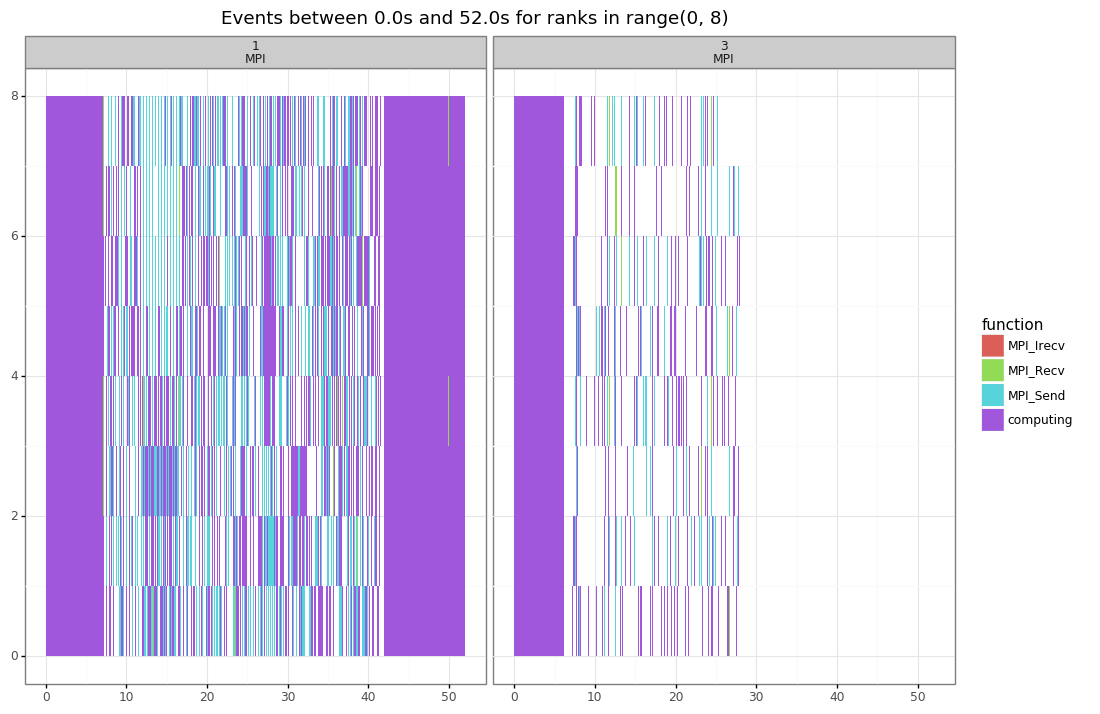

<ggplot: (8732435912021)>

In [48]:
plot_bounded(traces, 0, 52, range(8))

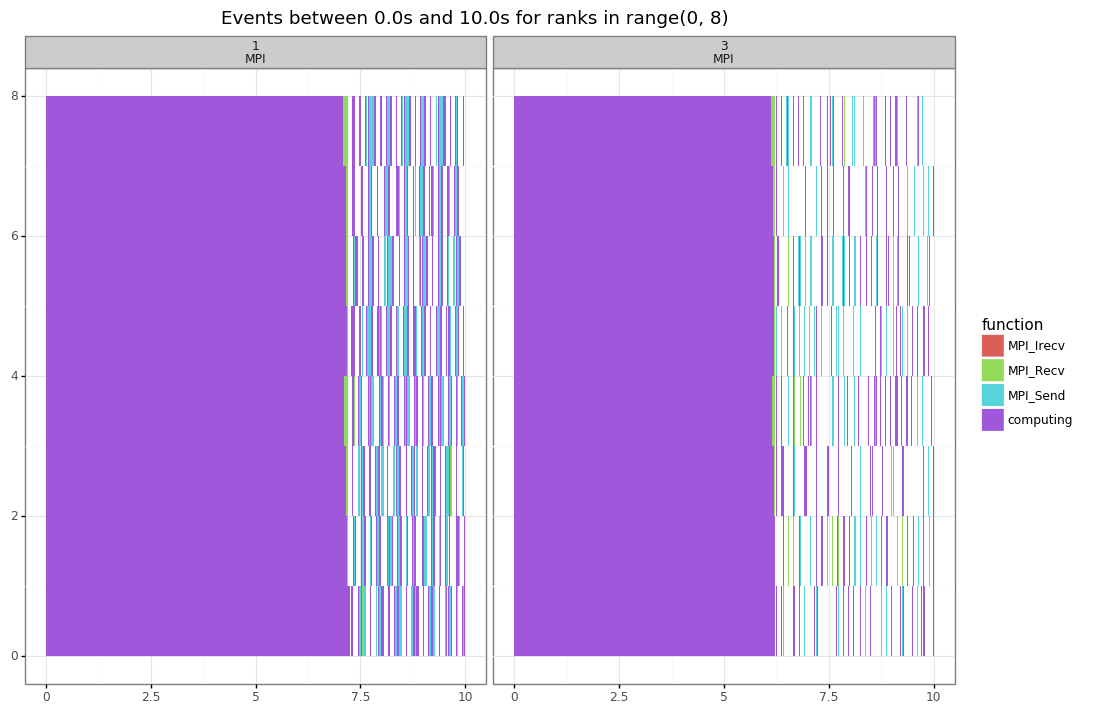

<ggplot: (8732302883732)>

In [49]:
plot_bounded(traces, 0, 10, range(8))

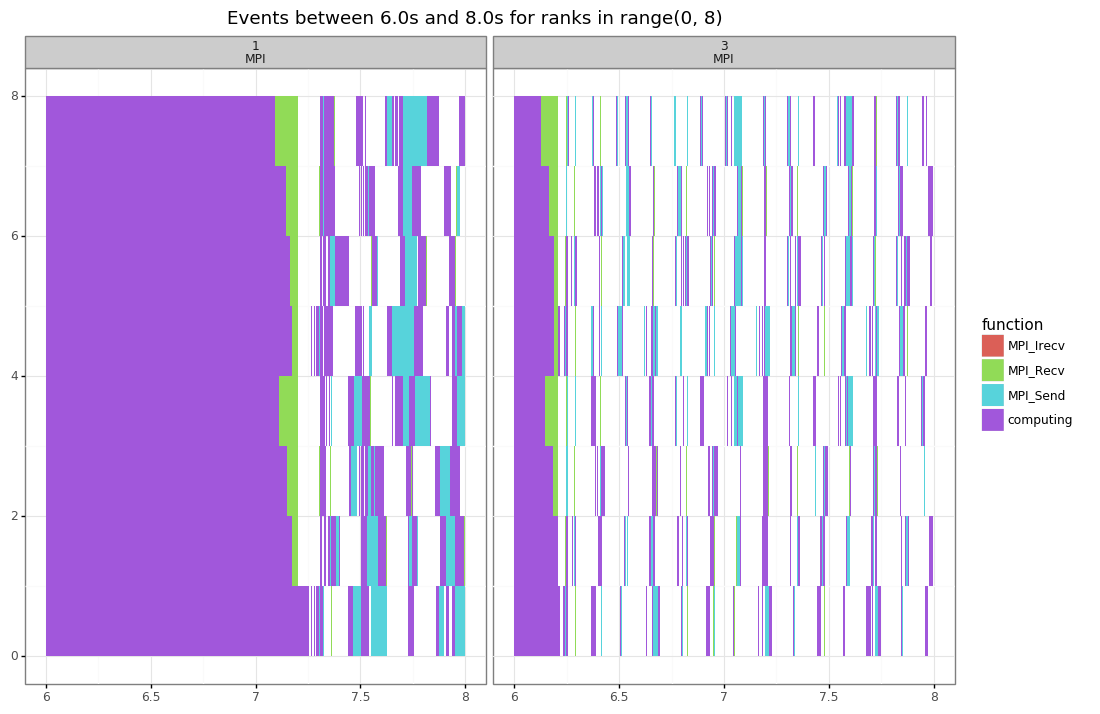

<ggplot: (8732309411967)>

In [50]:
plot_bounded(traces, 6, 8, range(8))

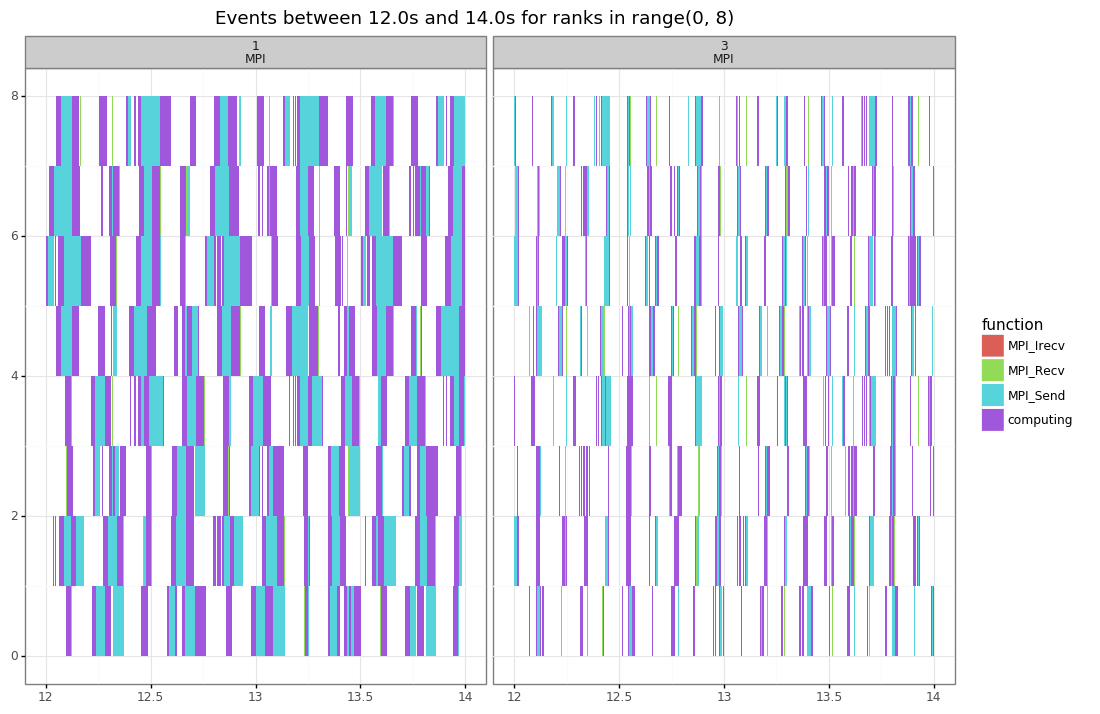

<ggplot: (8732308925234)>

In [51]:
plot_bounded(traces, 12, 14, range(8))

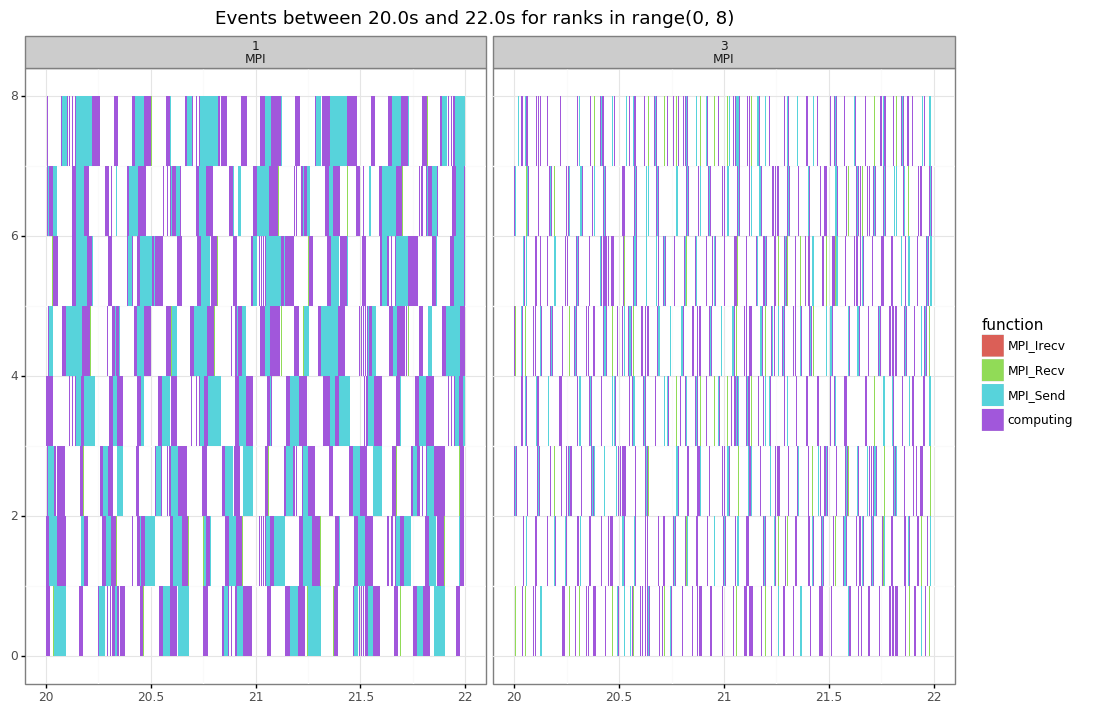

<ggplot: (8732292546280)>

In [52]:
plot_bounded(traces, 20, 22, range(8))

### Trying level 1 with no computations

In [53]:
build_hpl(job, 1)

[2019-01-14 09:39:00][DEBUG] [allnodes | /tmp/hpl-2.2] git clean -xfd .
[2019-01-14 09:39:00][DEBUG] [allnodes | /tmp/hpl-2.2] make SMPI_OPTS="-DSMPI_MEASURE -DSMPI_OPTIMIZATION_LEVEL=1" arch=SMPI


In [54]:
from peanut.smpi_hpl import TopoFile
import os
platform = [f for f in job.expfile if f.extension == 'xml']
assert len(platform) == 1
platform = TopoFile(platform[0])
expfile = [f for f in job.expfile if f.extension != 'xml']
assert len(expfile) == 1
expfile = expfile[0]
nb_cores = platform.core
job.nodes.write_files(platform.expfile.raw_content, os.path.join(job.hpl_dir, 'bin/SMPI/platform.xml'))
job.nodes.write_files('\n'.join(platform.hostnames), os.path.join(job.hpl_dir, 'bin/SMPI/hosts.txt'))

[2019-01-14 09:39:17][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpzbfykh0p → /tmp/hpl-2.2/bin/SMPI/platform.xml
[2019-01-14 09:39:18][DEBUG] [allnodes] put: /home/tom/Dropbox/Documents/Fac/phd/mpi_calibration/dahu/smpi_hpl/tmpnzgjj5nx → /tmp/hpl-2.2/bin/SMPI/hosts.txt


In [55]:
cmd =  'SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 '
cmd += 'TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIBRARY_PATH=/tmp/lib smpirun -wrapper /usr/bin/time --cfg=smpi/privatize-global-variables:dlopen '
cmd += '-np 8 --cfg=tracing:yes --cfg=tracing/filename:/tmp/trace_0.paje --cfg=tracing/smpi:1 --cfg=tracing/smpi/display-sizes:yes --cfg=tracing/smpi/computing:yes '
cmd += '--cfg=smpi/shared-malloc-hugepage:/root/huge --cfg=smpi/shared-malloc-blocksize:2097152 --cfg=smpi/display-timing:yes -platform platform.xml -hostfile hosts.txt '
cmd += '--cfg=smpi/simulate-computation:no ./xhpl'

resut = job.nodes.run(cmd, directory=job.hpl_dir + '/bin/SMPI')

[2019-01-14 09:39:18][DEBUG] [allnodes | /tmp/hpl-2.2/bin/SMPI] SMPI_DGEMM_COEFFICIENT=2.548998e-12 SMPI_DGEMM_INTERCEPT=9.905042e-05 SMPI_DTRSM_COEFFICIENT=4.524788e-12 SMPI_DTRSM_INTERCEPT=3.975362e-05 TIME="/usr/bin/time:output %U %S %F %R %P" LD_LIBRARY_PATH=/tmp/lib smpirun -wrapper /usr/bin/time --cfg=smpi/privatize-global-variables:dlopen -np 8 --cfg=tracing:yes --cfg=tracing/filename:/tmp/trace_0.paje --cfg=tracing/smpi:1 --cfg=tracing/smpi/display-sizes:yes --cfg=tracing/smpi/computing:yes --cfg=smpi/shared-malloc-hugepage:/root/huge --cfg=smpi/shared-malloc-blocksize:2097152 --cfg=smpi/display-timing:yes -platform platform.xml -hostfile hosts.txt --cfg=smpi/simulate-computation:no ./xhpl


In [56]:
job.nodes.run('pj_dump -u /tmp/trace_0.paje | grep -v MPI_Iprobe > trace_mpi_0.csv', directory='/tmp')

[2019-01-14 09:44:08][DEBUG] [allnodes | /tmp] pj_dump -u /tmp/trace_0.paje | grep -v MPI_Iprobe > trace_mpi_0.csv


{<Connection host=dahu-4.grenoble.grid5000.fr user=root gw=proxyjump>: <Result cmd='cd /tmp && pj_dump -u /tmp/trace_0.paje | grep -v MPI_Iprobe > trace_mpi_0.csv' exited=0>}

In [57]:
trace_level1_nocompute = get_trace(job, ['MPI_Recv', 'MPI_Send', 'MPI_Irecv', 'computing', 'dgemm', 'dtrsm', 'MPI_Bcast'], range(8))
trace_level1_nocompute.groupby(['function'])[['msg_size', 'duration']].agg(['sum'])

[2019-01-14 09:44:11][DEBUG] [allnodes | /tmp] grep -E "MPI_Recv|MPI_Send|MPI_Irecv|computing|dgemm|dtrsm|MPI_Bcast" /tmp/trace_mpi_0.csv | grep -E "rank-0|rank-1|rank-2|rank-3|rank-4|rank-5|rank-6|rank-7" > /tmp/mpi.csv
[2019-01-14 09:44:13][DEBUG] [allnodes] get: /tmp/mpi.csv → /tmp/mpi.csv


,msg_size,duration
,sum,sum
function,,
MPI_Irecv,15117079816,0.000000
MPI_Recv,30238677876,2.572734
MPI_Send,45355757692,7.235732


In [58]:
trace_level1_nocompute['optimization'] = 1
traces = pandas.concat([trace_level1_nocompute, trace_level3_altered])
traces['kind'] = 'MPI'

In [59]:
for opt in sorted(traces['optimization'].unique()):
    for kind in sorted(traces['kind'].unique()):
        df = traces[(traces['optimization'] == opt) & (traces['kind'] == kind)]
        print('optim %d, kind %s' % (opt, kind), df.start.min(), df.end.max())
    print()

optim 1, kind MPI 0.0 19.042304

optim 3, kind MPI 0.0 28.931953999999998



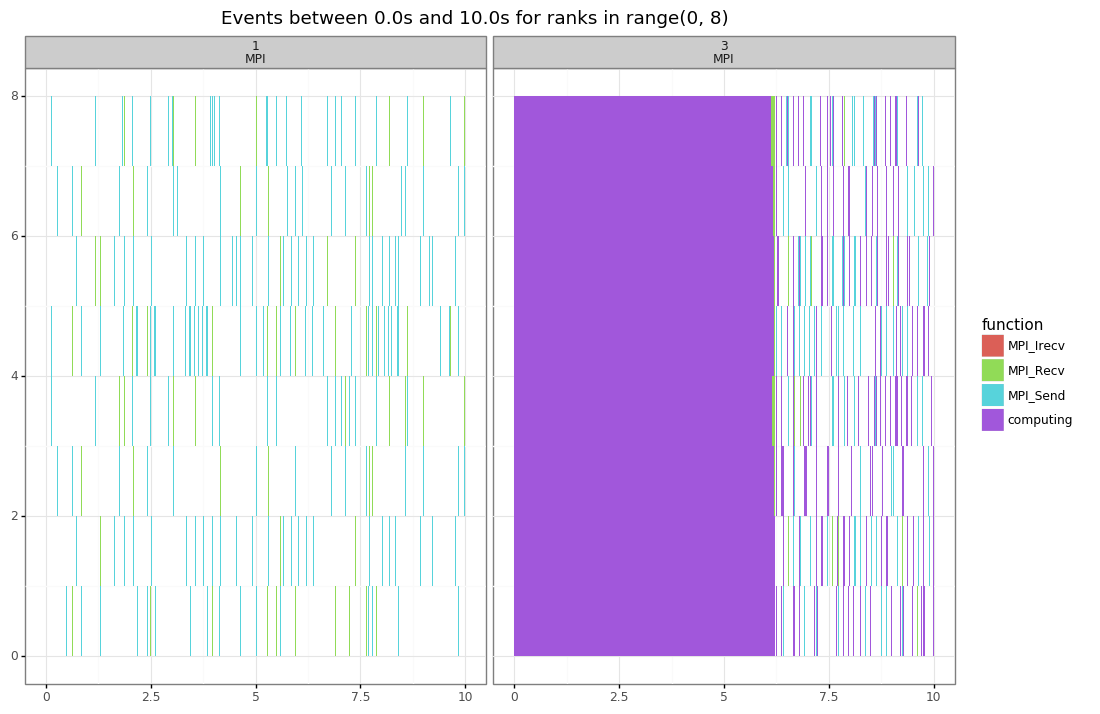

<ggplot: (-9223363304433800048)>

In [60]:
plot_bounded(traces, 0, 10, range(8))

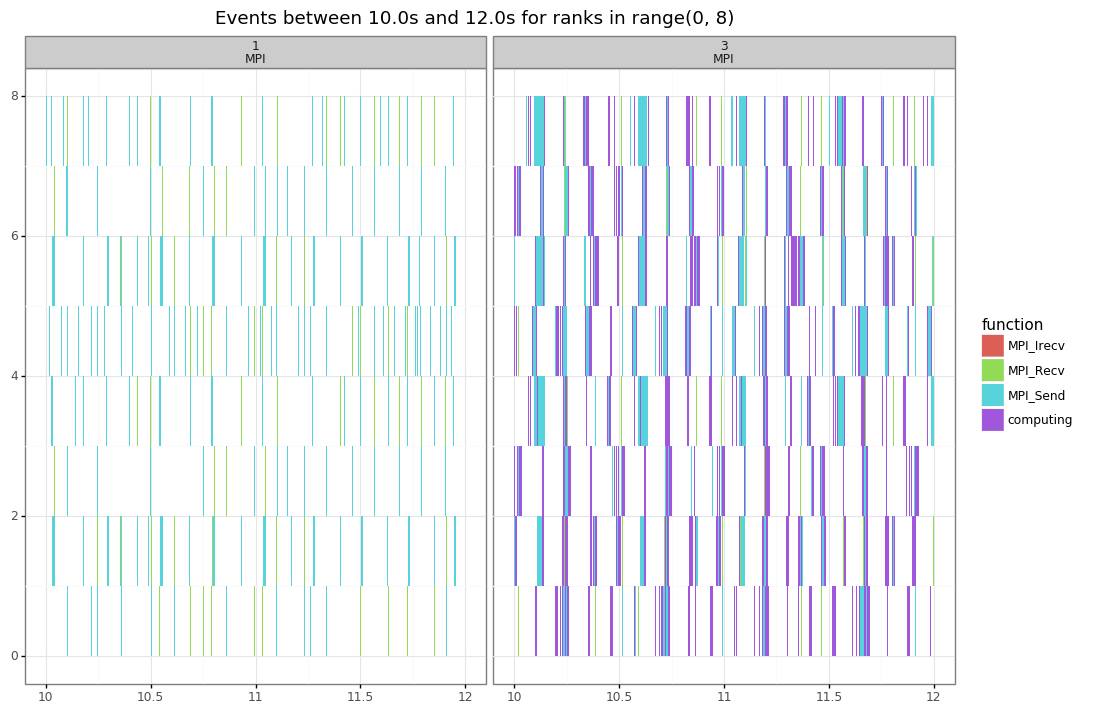

<ggplot: (-9223363304511806513)>

In [61]:
plot_bounded(traces, 10, 12, range(8))

## Deleting the job

In [62]:
job.oardel()

[2019-01-14 09:44:29][DEBUG] [frontend | /home/tocornebize] oardel 1839830
